In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np

# Set the device      
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
import importlib
try: 
    importlib.reload(generators)
    importlib.reload(utils)
    importlib.reload(trainers)
    importlib.reload(u_net)
    print("libs reloaded")
except:
    import generators
    import trainers
    import utils
    import u_net
    print("libs imported")

TrainerUNET = trainers.TrainerUNET

libs imported


# UNET

In [3]:
# directorys with data and to store training checkpoints and logs
WORKING_DIR = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project")
GIT_DIR = Path(r"C:\Users\20182371\Documents\TUe\CapitaSelectaCode")
DATA_DIR = WORKING_DIR / "TrainingData"
PROGRESS_DIR = WORKING_DIR / "progress_unet"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
VAEMASK_WEIGHTS = GIT_DIR / "Machine learning" / "weights" / "vaemask_200_epochs_16_zdim.pth" 
VAEGAN_WEIGHTS = GIT_DIR / "Machine learning" / "weights" / "vaegan_200_epochs_256_zdim_ema.pth" 

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]  # images are made smaller to save training time
N = 15
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
N_EPOCHS = 60
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-4
TOLERANCE = 0.001  # for early stopping
DISPLAY_FREQ = 5
Number_of_fake = 16
if Number_of_fake == 32:
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 32 - Number_of_fake
BATCH_SIZE_VALID = 32
EARLY_STOPPING = False
MINIMUM_VALID_LOSS = 10
exp = str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake"
EXPERIMENT_DIR = PROGRESS_DIR / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

utils.remove_empty_masks(DATA_DIR)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(sorted(patients), random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}

mask_generator = generators.VAE(spade=False).to(device)
mask_generator.load_state_dict(torch.load(VAEMASK_WEIGHTS, map_location=device))
mask_generator.eval()

image_generator = generators.VAEGAN(spade=True).to(device)
image_generator.load_state_dict(torch.load(VAEGAN_WEIGHTS, map_location=device))
image_generator.eval()

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

mask_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks=True)
mask_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )


In [4]:
unet_model = u_net.UNet(num_classes=1).to(device)
# optimizer = torch.optim.SGD(unet_model.parameters(), lr=LEARNING_RATE, momentum=0.95, nesterov=True, weight_decay=1e-3)
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=LEARNING_RATE, betas=(0.95, 0.999), weight_decay=1e-3)

In [5]:
u_net_trainer = TrainerUNET(net=unet_model, 
                            optimizer=optimizer, 
                            progress_dir=EXPERIMENT_DIR, 
                            train_loader=train_loader, 
                            valid_loader=valid_loader, 
                            mask_loader=mask_loader,
                            mask_generator=mask_generator,
                            image_generator=image_generator,
                            TOLERANCE = TOLERANCE,
                            minimum_valid_loss = MINIMUM_VALID_LOSS,
                            Number_of_fake = Number_of_fake,
                            CHECKPOINTS_DIR=EXPERIMENT_DIR, 
                            device=device,
                            early_stopping=False) 

In [6]:
u_net_trainer.train(N_EPOCHS, 1, lambda_lr=lambda_lr)

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #000: DiceBCELoss/train = 1.412 | DiceBCELoss/valid = 1.115


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #001: DiceBCELoss/train = 1.049 | DiceBCELoss/valid = 1.023


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #002: DiceBCELoss/train = 0.911 | DiceBCELoss/valid = 0.959


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #003: DiceBCELoss/train = 0.662 | DiceBCELoss/valid = 0.683


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #004: DiceBCELoss/train = 0.523 | DiceBCELoss/valid = 0.646


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #005: DiceBCELoss/train = 0.429 | DiceBCELoss/valid = 0.543


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #006: DiceBCELoss/train = 0.385 | DiceBCELoss/valid = 0.518


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #007: DiceBCELoss/train = 0.367 | DiceBCELoss/valid = 0.479


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #008: DiceBCELoss/train = 0.353 | DiceBCELoss/valid = 0.487


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #009: DiceBCELoss/train = 0.332 | DiceBCELoss/valid = 0.447


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #010: DiceBCELoss/train = 0.303 | DiceBCELoss/valid = 0.428


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #011: DiceBCELoss/train = 0.296 | DiceBCELoss/valid = 0.445


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #012: DiceBCELoss/train = 0.283 | DiceBCELoss/valid = 0.410


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #013: DiceBCELoss/train = 0.269 | DiceBCELoss/valid = 0.463


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #014: DiceBCELoss/train = 0.282 | DiceBCELoss/valid = 0.480


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #015: DiceBCELoss/train = 0.258 | DiceBCELoss/valid = 0.358


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #016: DiceBCELoss/train = 0.246 | DiceBCELoss/valid = 0.372


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #017: DiceBCELoss/train = 0.226 | DiceBCELoss/valid = 0.375


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #018: DiceBCELoss/train = 0.217 | DiceBCELoss/valid = 0.413


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #019: DiceBCELoss/train = 0.218 | DiceBCELoss/valid = 0.396


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #020: DiceBCELoss/train = 0.211 | DiceBCELoss/valid = 0.369


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #021: DiceBCELoss/train = 0.212 | DiceBCELoss/valid = 0.438


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #022: DiceBCELoss/train = 0.197 | DiceBCELoss/valid = 0.401


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #023: DiceBCELoss/train = 0.187 | DiceBCELoss/valid = 0.345


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #024: DiceBCELoss/train = 0.183 | DiceBCELoss/valid = 0.340


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #025: DiceBCELoss/train = 0.185 | DiceBCELoss/valid = 0.376


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #026: DiceBCELoss/train = 0.182 | DiceBCELoss/valid = 0.378


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #027: DiceBCELoss/train = 0.179 | DiceBCELoss/valid = 0.337


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #028: DiceBCELoss/train = 0.173 | DiceBCELoss/valid = 0.386


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #029: DiceBCELoss/train = 0.168 | DiceBCELoss/valid = 0.401


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #030: DiceBCELoss/train = 0.176 | DiceBCELoss/valid = 0.363


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #031: DiceBCELoss/train = 0.163 | DiceBCELoss/valid = 0.340


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #032: DiceBCELoss/train = 0.154 | DiceBCELoss/valid = 0.331


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #033: DiceBCELoss/train = 0.151 | DiceBCELoss/valid = 0.353


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #034: DiceBCELoss/train = 0.152 | DiceBCELoss/valid = 0.327


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #035: DiceBCELoss/train = 0.144 | DiceBCELoss/valid = 0.332


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #036: DiceBCELoss/train = 0.144 | DiceBCELoss/valid = 0.341


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #037: DiceBCELoss/train = 0.137 | DiceBCELoss/valid = 0.350


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #038: DiceBCELoss/train = 0.137 | DiceBCELoss/valid = 0.291


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #039: DiceBCELoss/train = 0.133 | DiceBCELoss/valid = 0.359


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #040: DiceBCELoss/train = 0.135 | DiceBCELoss/valid = 0.317


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #041: DiceBCELoss/train = 0.123 | DiceBCELoss/valid = 0.323


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #042: DiceBCELoss/train = 0.128 | DiceBCELoss/valid = 0.312


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #043: DiceBCELoss/train = 0.122 | DiceBCELoss/valid = 0.296


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #044: DiceBCELoss/train = 0.121 | DiceBCELoss/valid = 0.325


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #045: DiceBCELoss/train = 0.115 | DiceBCELoss/valid = 0.297


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #046: DiceBCELoss/train = 0.112 | DiceBCELoss/valid = 0.323


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #047: DiceBCELoss/train = 0.115 | DiceBCELoss/valid = 0.311


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #048: DiceBCELoss/train = 0.107 | DiceBCELoss/valid = 0.330


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #049: DiceBCELoss/train = 0.109 | DiceBCELoss/valid = 0.313


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #050: DiceBCELoss/train = 0.107 | DiceBCELoss/valid = 0.311


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #051: DiceBCELoss/train = 0.110 | DiceBCELoss/valid = 0.317


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #052: DiceBCELoss/train = 0.102 | DiceBCELoss/valid = 0.291


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #053: DiceBCELoss/train = 0.100 | DiceBCELoss/valid = 0.300


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #054: DiceBCELoss/train = 0.098 | DiceBCELoss/valid = 0.295


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #055: DiceBCELoss/train = 0.095 | DiceBCELoss/valid = 0.294


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #056: DiceBCELoss/train = 0.092 | DiceBCELoss/valid = 0.301


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #057: DiceBCELoss/train = 0.094 | DiceBCELoss/valid = 0.304


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #058: DiceBCELoss/train = 0.092 | DiceBCELoss/valid = 0.316


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #059: DiceBCELoss/train = 0.093 | DiceBCELoss/valid = 0.298


best valid loss = 0.29071104526519775


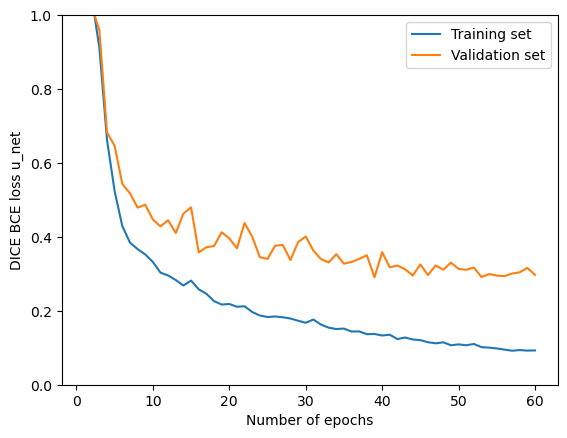

In [7]:
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.train_losses[0])
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('DICE BCE loss u_net')
plt.ylim([0, 1])
plt.legend(['Training set', 'Validation set'])
plot_name = 'DICE_BCE_LOSS_'+ str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake.png"
path = EXPERIMENT_DIR / plot_name

print(f"best valid loss = {min(u_net_trainer.valid_losses[0])}")
np.savetxt(EXPERIMENT_DIR / "results_train.csv", u_net_trainer.train_losses[0], delimiter=",")
np.savetxt(EXPERIMENT_DIR / "results_valid.csv", u_net_trainer.valid_losses[0], delimiter=",")
plt.savefig(path, dpi=200)